In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import tensorflow as tf


gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

In [3]:
import tensorflow_datasets as tfds

tfds.__version__

'3.2.1'

In [4]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [5]:
print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

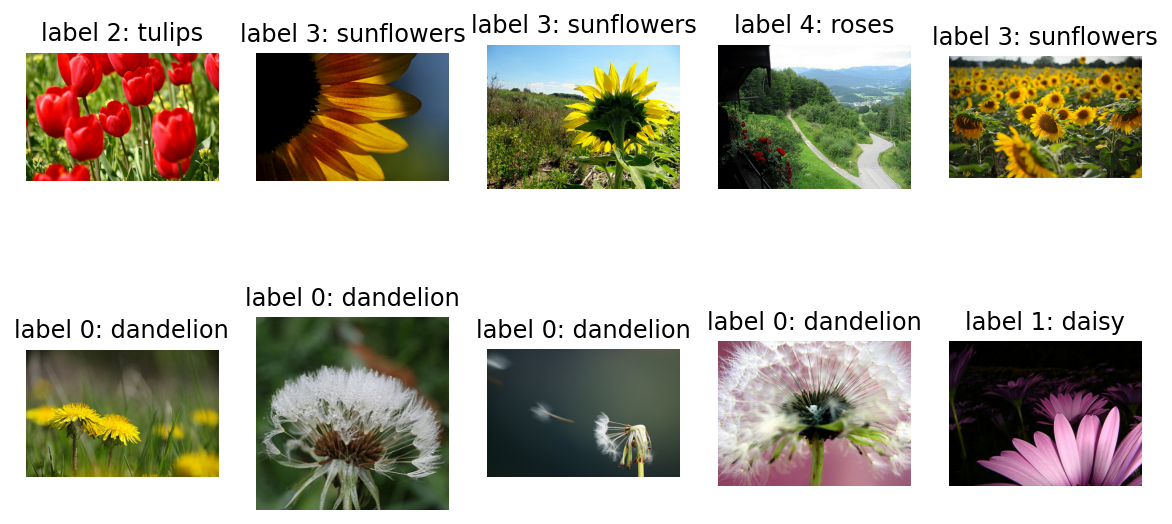

In [7]:
plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

In [8]:
IMG_SIZE = 160

def format_example(image, label):
    image = tf.cast(image, tf.float32)  
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [9]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

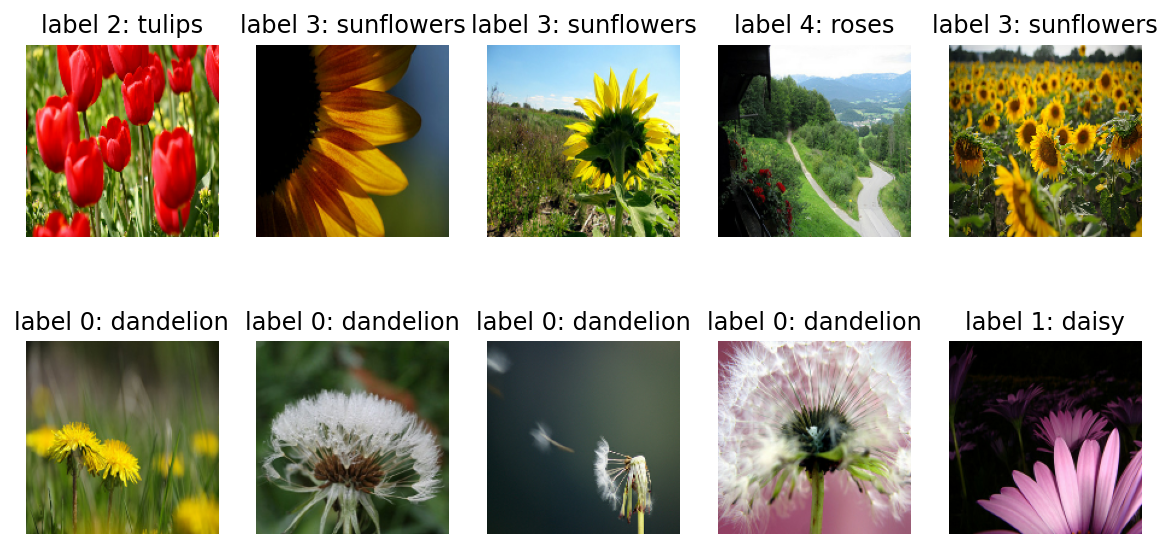

In [10]:
plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint

In [12]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model VGG16
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

In [13]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)


In [14]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model VGG16
base_model = tf.keras.applications.VGG19(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

80142336/80134624 [==============================] - 6s 0us/step


In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
dense_layer = tf.keras.layers.Dense(512, activation='relu')
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')
normalization_layer = tf.keras.layers.BatchNormalization(momentum=0.8)

In [16]:
base_model.trainable = True
model = tf.keras.Sequential([
  base_model,
  normalization_layer,
  global_average_layer,
  dense_layer,
  prediction_layer
])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 5, 5, 512)         20024384  
_________________________________________________________________
batch_normalization (BatchNo (None, 5, 5, 512)         2048      
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2565      
Total params: 20,291,653
Trainable params: 20,290,629
Non-trainable params: 1,024
_________________________________________________________________


In [19]:
import datetime
base_learning_rate = 0.00001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

EPOCHS = 100  

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches,
                    callbacks=[tensorboard_callback])

Epoch 1/100
92/92 [==============================] - 436s 5s/step - loss: 1.0888 - accuracy: 0.6192 - val_loss: 0.7254 - val_accuracy: 0.7820
Epoch 2/100
92/92 [==============================] - 419s 5s/step - loss: 0.4955 - accuracy: 0.8430 - val_loss: 0.4553 - val_accuracy: 0.8474
Epoch 3/100
92/92 [==============================] - 410s 4s/step - loss: 0.3107 - accuracy: 0.9097 - val_loss: 0.3771 - val_accuracy: 0.8692
Epoch 4/100
92/92 [==============================] - 410s 4s/step - loss: 0.2246 - accuracy: 0.9298 - val_loss: 0.3738 - val_accuracy: 0.8638
Epoch 5/100
92/92 [==============================] - 410s 4s/step - loss: 0.1622 - accuracy: 0.9564 - val_loss: 0.3270 - val_accuracy: 0.8910
Epoch 6/100
92/92 [==============================] - 412s 4s/step - loss: 0.1048 - accuracy: 0.9775 - val_loss: 0.3024 - val_accuracy: 0.8937
Epoch 7/100
92/92 [==============================] - 402s 4s/step - loss: 0.0714 - accuracy: 0.9881 - val_loss: 0.3451 - val_accuracy: 0.8828
Epoch 

92/92 [==============================] - 569s 6s/step - loss: 0.1244 - accuracy: 0.9561 - val_loss: 0.3818 - val_accuracy: 0.9183
Epoch 59/100
92/92 [==============================] - 424s 5s/step - loss: 0.0284 - accuracy: 0.9925 - val_loss: 0.3041 - val_accuracy: 0.9210
Epoch 60/100
92/92 [==============================] - 430s 5s/step - loss: 0.0076 - accuracy: 0.9969 - val_loss: 0.3488 - val_accuracy: 0.9155
Epoch 61/100
92/92 [==============================] - 463s 5s/step - loss: 0.0062 - accuracy: 0.9986 - val_loss: 0.3413 - val_accuracy: 0.9183
Epoch 62/100
92/92 [==============================] - 464s 5s/step - loss: 0.0027 - accuracy: 0.9997 - val_loss: 0.3248 - val_accuracy: 0.9237
Epoch 63/100
92/92 [==============================] - 459s 5s/step - loss: 0.0018 - accuracy: 0.9997 - val_loss: 0.3296 - val_accuracy: 0.9210
Epoch 64/100
92/92 [==============================] - 502s 5s/step - loss: 0.0016 - accuracy: 0.9993 - val_loss: 0.3172 - val_accuracy: 0.9264
Epoch 65/100

In [20]:
import numpy as np

image = np.array([[1, 2], [3, 4]])
print(image.shape)
image

(2, 2)


array([[1, 2],
       [3, 4]])

In [21]:
image.flatten()

array([1, 2, 3, 4])

In [22]:
base_learning_rate = 0.00001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [23]:
validation_steps = 11
loss0, accuracy0 = model.evaluate(validation_batches, steps=validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

11/11 [==============================] - 9s 810ms/step - loss: 0.3673 - accuracy: 0.9261
initial loss: 0.37
initial accuracy: 0.93


In [26]:
# 모델 학습시키기
import time
start=time.time()


EPOCHS = 1
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches,
                    callbacks=[tensorboard_callback])

92/92 [==============================] - 422s 5s/step - loss: 0.0011 - accuracy: 0.9993 - val_loss: 0.5455 - val_accuracy: 0.8992


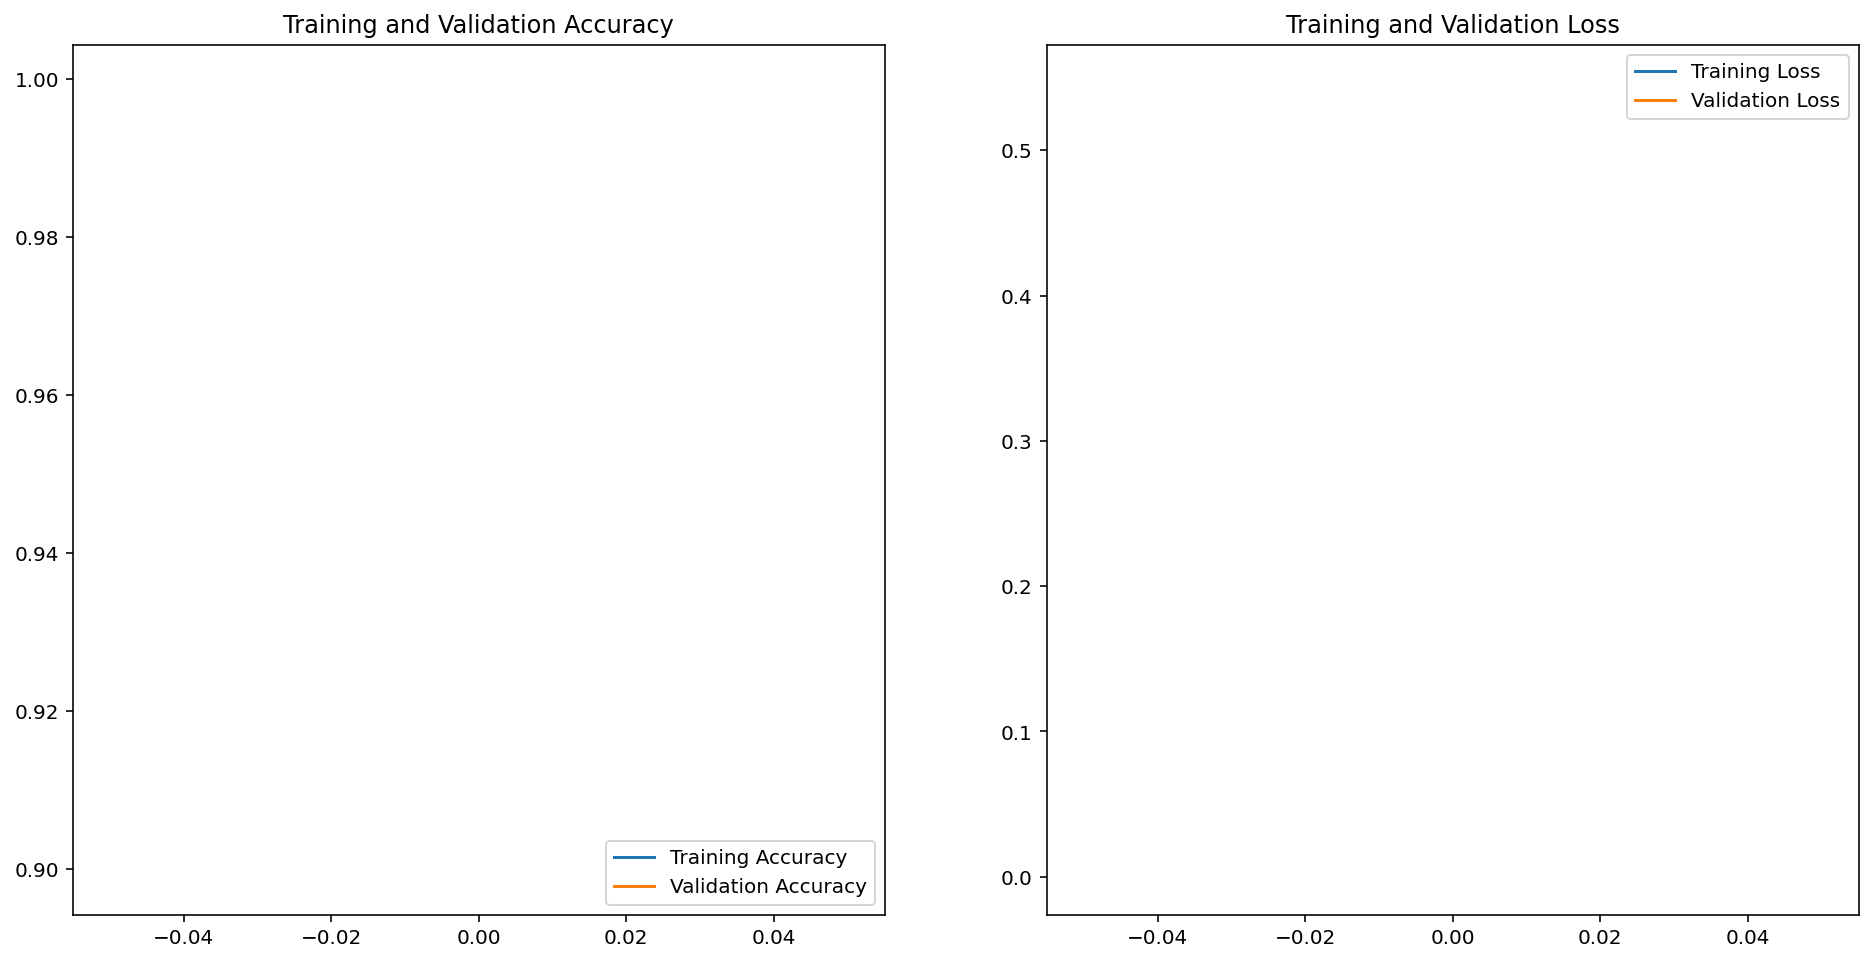

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

array([[5.24570387e-05, 1.54755064e-04, 2.85959225e-02, 1.28361199e-03,
        9.69913244e-01],
       [9.99990225e-01, 3.63563731e-06, 1.26990210e-06, 2.33336527e-06,
        2.47118533e-06],
       [9.98752117e-01, 5.25291625e-06, 2.84991160e-07, 1.24030921e-03,
        2.11061865e-06],
       [1.19358796e-04, 3.74424009e-04, 2.02138275e-01, 8.38454813e-04,
        7.96529472e-01],
       [9.99872684e-01, 5.72165300e-05, 3.57226854e-05, 7.74284672e-06,
        2.66172701e-05],
       [9.99987483e-01, 7.94618245e-06, 5.29392651e-07, 2.42399665e-06,
        1.66000143e-06],
       [1.68794286e-05, 4.64837240e-06, 9.99483466e-01, 2.59681747e-06,
        4.92298044e-04],
       [1.07127086e-07, 9.99997735e-01, 9.40827327e-09, 1.63473430e-06,
        5.26201859e-07],
       [2.55308108e-09, 7.52940932e-10, 2.02718189e-10, 1.00000000e+00,
        3.44249251e-09],
       [9.99978781e-01, 6.42944406e-06, 3.39875828e-06, 6.48455034e-06,
        4.85282908e-06],
       [9.99979615e-01, 1.2726

In [29]:
import numpy as np
predictions = np.argmax(predictions, axis=1)
predictions

array([4, 0, 0, 4, 0, 0, 2, 1, 3, 0, 0, 0, 3, 4, 0, 3, 2, 0, 2, 4, 2, 0,
       1, 0, 1, 3, 1, 4, 4, 3, 0, 4])

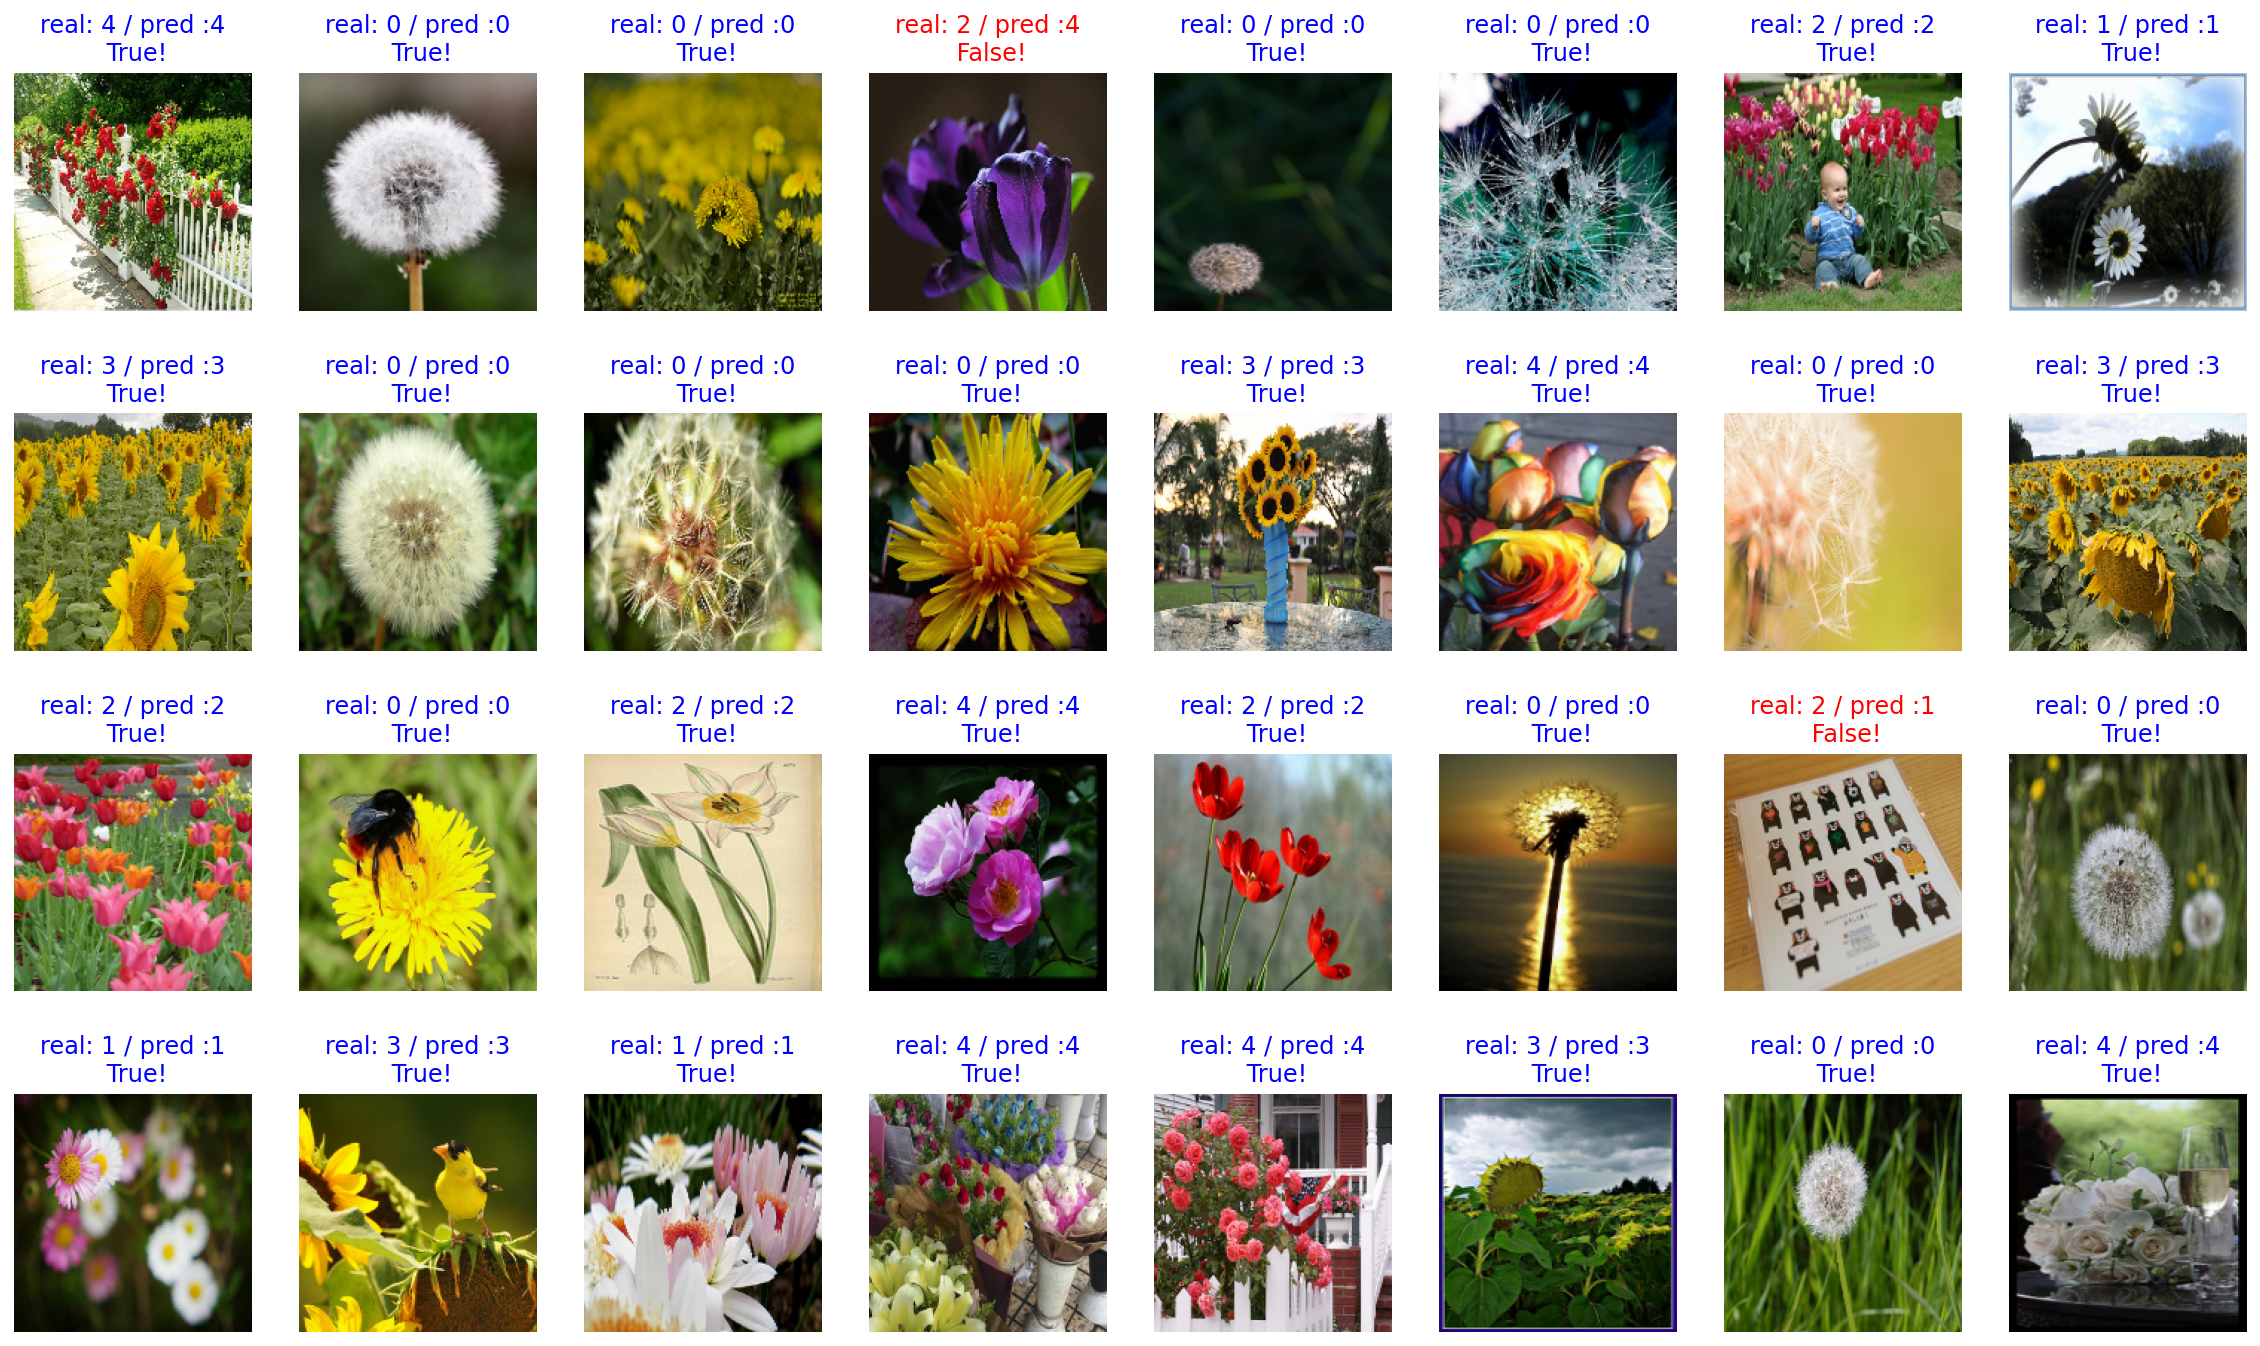

In [31]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

In [32]:
count = 0   # 정답을 맞춘 개수
for image, label, prediction in zip(images, labels, predictions):
    # [[YOUR CODE]]


    print(count / 32 * 100)    # 약 70% 내외

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [48]:
import os

checkpoint_dir = os.getenv("HOME") + "/content/drive/My Drive/PROJECT_CHECKPOINT/tf_flowers/"
checkpoint_file_path = os.path.join(checkpoint_dir, 'checkpoint')

if not os.path.exists('checkpoint_dir'):
    os.mkdir('checkpoint_dir')
    
model.save_weights(checkpoint_file_path)     # checkpoint 파일 생성

if os.path.exists(checkpoint_file_path):
  print('checkpoint 파일 생성 OK!!')

checkpoint 파일 생성 OK!!
